# Finite-volume approach on the Lattice Boltzmann Method in 2D

Eddy de Haas (1450077)

## Introduction

The Lattice Boltzmann Method (LBM) is a computational method for solving fluid dynamic problems which uses particle distributions on a lattice to model the fluid. Instead of solving the Navier-Stokes equations, the fluid is simulated with streaming and collision processes to mimic its movement and collisions with objects. While the LBM is fairly simple to code and can be run very efficiently by parallelising the simulation, it also has some disadvantages. LBM is typically restricted to a regularly spaced uniform lattice which, compared to other computational fluid dynamics (CFD) methods, may not be able to simulate more complex fluid domains accurately. To circumvent this problem and to be able to implement LBM on more complex fluid problems, a finite-volume approach is proposed by Haowen Xi et al. [1]. Instead of performing calculations using the distributions on only the gridpoints, the method interpolates these distributions in between the gridpoints and by using the information on the shape of the irregular grid, the fluid properties over a whole cell can be calculated.

In this notebook, a Lattice Boltzmann Method solver is written which implements a finite-volume approach to solve a fluid dynamics problem on an irregular two-dimensional grid following the approach by Haowen Xi et al. 



## Theory

The finite-volume lattice Boltzman method (FVLBM) will solve the lattice Boltzmann equation given by

$$
\frac{\partial f_i}{\partial t} + \textbf{v}_i \cdot \mathbf{\nabla} f_i = \Omega_i + \alpha \textbf{v}_i \cdot \textbf{F},
\tag{1}$$

where $f_i$ is the particle distribution function along the $i^\textrm{th}$ direction. $\textbf{F}$ is the body force acting on the fluid. $\Omega_i$ is the collision operator aproximated by the BGK-model given by

$$
\Omega_i = -\frac{1}{\tau} (f_i - f_i^{eq}).
\tag{2}$$

In this notebook, a two-dimensional grid will be used. Therefore, the D2Q9 velocity model will be used. The velocity vectors corresponding to this set are given as

$$
\mathbf{v}_i = \{(0,0), (1,0), (0,1), (-1,0), (0,-1), (1,1), (-1,1), (-1,-1), (1,-1)\}
\tag{3}$$

the weights for these directions are given respectively as 

$$
w_i = \{ 4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36\}
\tag{4}$$

The two-dimensional grid will consist out of quadrilateral elements. A generic gridpoint is shown in Figure 1 below. The finite-volume element corresponding to gridpoint $P$ is the polygon $ABCDEFGH$. In the finite-volume method, the flux through the edges and the collisions of this polygon is calculated and used to update the particle distributions in each time step.

The update of the particle distribution is given as

$$
f_i(P,t+\Delta t) = f_i(P,t) + \frac{\Delta t}{S_p} \Big( \sum_{\mathrm{around} \, P} (\mathrm{collisions}) - \sum_{\mathrm{around} \, P} (\mathrm{fluxes}) + \alpha \textbf{v}_i \cdot \textbf{F} \Big)
\tag{5}$$

The summations are performed over all four quarters of the polygon around point $P$. For the highlighted quarter $PABC$, the contribution to the flux term is given as

$$
\int_{PABC} \mathbf{v}_i \cdot \mathbf{\nabla} f_i \mathrm{d}\sigma = \mathbf{v}_i \cdot \mathbf{n}_{AB} l_{AB} [ f_i(A) + f_i(B)]/2 + \mathbf{v}_i \cdot \mathbf{n}_{BC} l_{BC} [ f_i(B) + f_i(C)]/2 + I_s
\tag{6}$$

with $I_s$ being the fluxes through the internal edges $PA$ and $PC$ of the polygon $ABCDEFGH$, which will cancel when summing over all four quarters. The contribution to the collision term by the quarter $PABC$ is given as

$$
\int_{PABC} \frac{1}{\tau} (f_i - f_i^\mathrm{eq}) \mathrm{d}\sigma = -\frac{S_{PABC}}{\tau} [ \Delta f_i(P) + \Delta f_i(A) + \Delta f_i(B) + \Delta f_i(C)]/4
\tag{7}$$

<div>
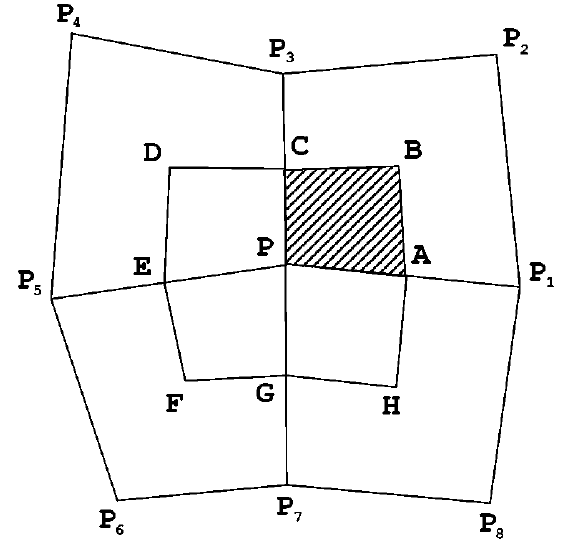
</div>

Figure 1: Diagram of gridpoint and surrounding finite-volume element (from Haowen Xi [1])

## Numerical Method

For the implementation of the finite-volume scheme, an object-oriented approach is used. Each gridpoint will be represented by an object which has attributes such as its index, $x$ and $y$ positions, the gridpoint type (used for boundary conditions), areas and lengths of surrounding polygon quarters etcetera. This has the advantage that when debugging the code, the data of a single gridpoint can easily be visualised and no big arrays containing all the attributes of each gridpoint need to be searched for the correct gridpoint. Later, the code can be rewritten into a vectorized implementation in which these big arrays can be used. This will help to improve the execution time as the simulation can be parallelized.

For the simulation, the libraries numpy and matplotlib are used, as well as the python file Grid.py which includes the custom classes and functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Grid import gridpoint, lattice

The lattice is also represented as an object, which contains an arrya with all the gridpoints as its attribute. The lattice is created by giving the number of gridpoints $N_x$ and $N_y$ in the $x$ and $y$ directions respectively as shown in the cell below.

In [2]:
Nx = 21
Ny = 13
field = lattice(Nx, Ny)

Next, the locations of the gridpoints are given to the 'field' object. This is done by the functions 'set_x_values()' and 'set_y_values()'. Following that, the gridpoint types are set, which tells if the gridpoint is a normal (= 0), periodic boundary (= 1) or no-slip boundary gridpoint (= 2). After that, the neighbours of each gridpoint is determined as well as the lengths, normals and areas of the polygons surrounding each gridpoint. This data is later used for the flux and collision calculations as given in Eqs. 6 & 7.

In [3]:
yval = []

for d in range(Ny):
    yval += Nx*[d/(Ny-1)]

typeval = []

typeval += Nx*[1]

for d in range(Ny-2):
    typeval += [1] + (Nx-2)*[0] + [1]
    
typeval[int((Nx*Ny)/2)] = 2

typeval += Nx*[1]

In [4]:
field.set_x_values(np.tile(np.linspace(0, 1, Nx), Ny))
field.set_y_values(yval)
field.set_type(typeval)
field.set_neighbours()
field.set_subpoints()
field.set_lengths()
field.set_normals()
field.set_areas()
field.calculate_equilibrium()

Now that the lattice has been initialised, the grid can be shown using the function 'show_grid()'. It takes one boolean argument called 'with_dist', which can enable the plotting of the distribution on the grid. The colours of the gridpoints indicate the type of gridpoint: black = normal, blue = periodic and red = no-slip. This looks as follows:

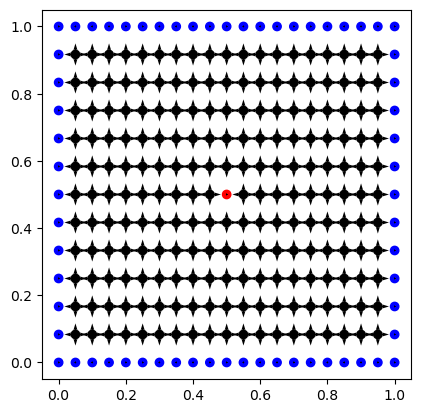

In [5]:
field.show_grid(with_dist = True)

After creating the grid, the simulation can be started. This will be done using the function 'iterate()'. Unfortunately, I was not able to fully complete the simulation and therefore, the simulation is not working at the moment. Furthermore, the implementation of the periodic and no-slip gridpoints has also not been finished.

## Conclusion and Outlook

In this notebook, a two dimensional finite-volume approach of the lattice Boltzmann method based on the report of Haowen et al. has partly been implemented. The goal of this approach is to be able to perform LBM simulations on irregular grids to be able to solve fluid problems on more complex grids than could be done using a regular evenly-spaced grid.

As mentioned, the code is not completed as the periodic and no-slip gridpoints have not been implemented completely. Additionally, the calculation of the new particle distribution using the fluxes and collisions and the previous distribution is not fully implemented.

When the code is fully finished, it is possible to input any grid, as long as it is a structured quadrilateral one. It can therefore be used to simulate the flow around an airfoil for example. This can be done by placing no-slip gridpoints in the shape of the airfoil in the middle of a domain and connecting these gridpoints properly to the rest of the gridpoints in the domain.

Another idea for the future would be to vectorize the simulation such that it can be parallelised to reduce the execution time of the code. Futhermore, in the mentioned report by Haowen, a three dimensional implementation of the finite-volume method is also mentioned which uses a D3Q19 model. This can also be implemented in the future to solve three dimensional fluid problems on irregular grid.

Even though I was not able to fully implement the method, I still think it was an interesting project and I learned a lot about the method and how to code it in Python.

## References

[1] Haowen Xi, Gongwen Peng, and So-Hsiang Chou. Finite-volume lattice Boltzmann schemes in two and three dimensions. *Physical Review E*, 60(3), September 1999